In [6]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
import jieba
import re
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn import cross_validation, metrics


file = pd.read_excel("C:/Users/Administrator.SC-201905252025/Desktop/small.xlsx", 
                     sheet_name='Sheet1', names=['authaccount','from_id', 'to_id', 'content'],encoding='utf-8')
df = pd.DataFrame(file)
df['content'] = df['content'].astype(str)
# k = df.shape[0]
# df = df.iloc[0:k//74,:]

keyword = [line.strip() for line in open("C:/Users/Administrator.SC-201905252025/Desktop/qg_keywords.txt", 'r', encoding="UTF-8").readlines()]
# stopWord = [line.strip() for line in open("C:/Users/Administrator.SC-201905252025/Desktop/test/stopword.txt",'r',encoding='utf-8').readlines()]

jieba.load_userdict("C:/Users/Administrator.SC-201905252025/Desktop/qg_keywords.txt")

# def cutword(sent):
# #     sent=re.sub(r'[a-zA-Z0-9]*','',sent)
#     wordList=jieba.lcut(sent,cut_all=True)
# #     tmp = [word for word in wordList if word not in stopWord and len(word)>1]
#     words = list(set(wordList))
#     return words

def cutwordtostr(sent):
#     sent=re.sub(r'[a-zA-Z0-9]*','',sent)
    wordList=jieba.lcut(sent,cut_all=True)
#     tmp = [word for word in wordList if word not in stopWord and len(word)>1]
    words = list(set(wordList))
    return [words,' '.join(words)]

def key_count(words):
#     words = cutword(sent)
    count_dict,key_list={},[]
    for i in keyword:
        a=words.count(i)
        if a>0:
            count_dict[i]=a
#             key_list.append(i+'('+str(a)+')')
    return [len(count_dict),sum(count_dict.values())]

def vectorize(df):
#     count_vect = CountVectorizer(min_df=1,analyzer='word')
    count_vect = TfidfVectorizer(binary=False,decode_error='ignore')
#     count_vect = HashingVectorizer(n_features=30)
    word_vec = count_vect.fit_transform(df['cutwordstr'])
    df['vec'] = word_vec.todense().tolist()
    return df
#     return word_vec.todense()

# df['cutword'] = df['content'].apply(cutword)
df['result'] = df['content'].apply(cutwordtostr)
df['cutword'] = df['result'].apply(lambda x:x[0])
df['cutwordstr'] = df['result'].apply(lambda x:x[1])

df['result'] = df['cutword'].apply(key_count)
df['word_count'] = df['result'].apply(lambda x:x[0])
df['key_count'] = df['result'].apply(lambda x:x[1])

df.drop(['result'], axis=1, inplace=True)
df = vectorize(df)
df=df.sort_values(by=['key_count'])

df_positive = df.loc[(df.key_count>2) & (df.word_count>1)]
df_positive['label'] = 0
df_negative = df.loc[df.key_count<2,].iloc[0:df_positive.shape[0]]
df_negative['label'] = 1
df_train = pd.concat([df_positive,df_negative])


# KNN
# model = KNNC(n_neighbors=5,n_jobs=-1,weights='uniform',algorithm='auto',leaf_size=1,metric='minkowski',p=2,metric_params=None)

# SVC
# model = SVC()

# 随机森林
model = RandomForestClassifier()

model.fit(np.array(df_train['vec']).tolist(), np.array(df_train['label']))
df['label'] = model.predict(np.array(df['vec']).tolist())


df.drop(['key_count','word_count', 'cutword', 'cutwordstr','vec'], axis=1, inplace = True)


writer = pd.ExcelWriter("C:/Users/Administrator.SC-201905252025/Desktop/rf1.xlsx", engine='xlsxwriter',options={'strings_to_urls':False})
writer.book.strings_to_urls = False
df.to_excel(writer, 'Sheet1', index=False)
writer.save()
print(1)

d:\python35\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python35\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1


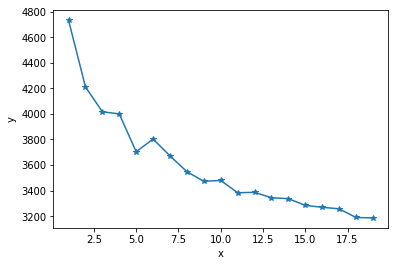

In [2]:
import matplotlib.pyplot as plt
# import numpy as np

def classCluster(df, num):
    km = KMeans(n_clusters=num, max_iter=300, n_init=40,init='k-means++',n_jobs=-1)
    result = km.fit_predict(np.mat(df['vec'].tolist()))
    result = result.tolist()
    df['label'] = result
    df.drop(['vec'], axis=1, inplace=True)
    return df

#     SSE = []
#     for k in range(1,20):
#         estimator = KMeans(n_clusters=k)
#         estimator.fit(df['vec'].tolist())
#         SSE.append(estimator.inertia_)
#     print(SSE)
#     return 0

Y = [4732.739779622297, 4211.482046705363, 4016.897811474795, 3999.976586479355, 3704.5390716951943, 3803.2547988284127, 3671.9133727458648, 3548.060168581349, 3472.911106259248, 3479.5827524936567, 3383.489112807599, 3386.412819489496, 3344.4548905091506, 3337.1134537250528, 3284.740983406511, 3269.453638544495, 3257.722748733844, 3189.831129397336, 3186.4612777661123]
x = range(1,20)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, Y, '*-')
plt.show()

In [2]:
# 交叉验证 网格搜索
from sklearn.grid_search import GridSearchCV    
from sklearn.svm import SVC   

model = SVC(kernel='rbf', probability=True)    
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}    
grid_search = GridSearchCV(model, param_grid, n_jobs = 8, verbose=1)    
grid_search.fit(train_x, train_y)    
best_parameters = grid_search.best_estimator_.get_params()    
for para, val in list(best_parameters.items()):    
    print(para, val)    
model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)    
model.fit(train_x, train_y)    
return model

   a  b  c  d
1  2  5  8  2
2  3  6  9  3
